# Кластерный анализ

Автор: Аббакумов Вадим Леонардович

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn import preprocessing
from sklearn.cluster import KMeans
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

In [ ]:
os.chdir('/content/gdrive/MyDrive/Colab_data/data_ML/')

## Задача

Проанализировать данные о безалкогольных напитках. В файле содержатся данные о том, какие напитки пили опрашиваемые из фокус-группы.

## 1. Иерархический кластерный анализ

In [ ]:
df = pd.read_csv("beverage_r.csv", sep=";", index_col='numb.obs')
df.head()

,COKE,D_COKE,D_PEPSI,D_7UP,PEPSI,SPRITE,TAB,SEVENUP
numb.obs,,,,,,,,
1,1,0,0,0,1,1,0,1
2,1,0,0,0,1,0,0,0
3,1,0,0,0,1,0,0,0
4,0,1,0,1,0,0,1,0
5,1,0,0,0,1,0,0,0


Применим алгоритм иерархической кластеризации и построим дендрограмму. Все необходимые вычисления проводятся в функции linkage. Кроме самих данных, ей нужно передать на вход два аргумента: метод вычисления расстояний между кластерами (```ward```, ```single```, ```complete```, ```average```) и метрику (```euclidean``` (default), ```cityblock``` aka Manhattan, ```hamming```, ```cosine```). См. [документацию]( https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html).

In [ ]:
# Объект, в котором будет хранится информация о последовательном слиянии кластеров
link = linkage(df, 'ward', 'euclidean')

Объект ```link``` представляет собой матрицу ```(n-1) x 4```, где ```n``` - число наблюдений. Каждая строка матрицы представляет собой результат слияния очередной пары кластеров с номерами ```link[i, 0]``` и ```link[i, 1]```. Новому кластеру присваивается номер ```n + i```. ```link[i, 2]``` означает расстояние между слитыми кластерами, а ```link[i, 3]``` - размер нового кластера.

In [ ]:
link[:5]

array([[ 5., 10.,  0.,  2.],
       [ 1.,  2.,  0.,  2.],
       [ 4., 35.,  0.,  3.],
       [ 3., 22.,  0.,  2.],
       [20., 36.,  0.,  4.]])

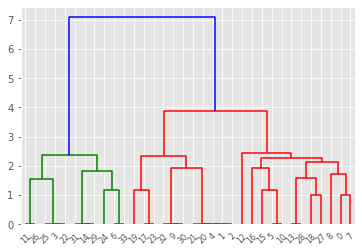

In [ ]:
# Функция для построения дендрограммы
dn = dendrogram(link)

Алгоритм подкрасил в дендрограмме два кластера, но здесь, скорее, кластера всё-таки три. Теперь хочется посмотреть, какими характеристиками различаются наши кластеры.

Сначала добавим к данным колонку ```cluster```, в которую запишем номер кластера, в которую попал объект. Это сделаем с помощью функции ```fcluster```. В качестве первого аргумента передаём объект ```linkage```, полученный выше. Третьим аргументом ```criterion``` передаём критерий для разбиения на кластеры (```distance``` для остановки разбиения по расстоянию между кластерами и ```maxclust``` для разбиения по заданному числу кластеров). Вторым же аргументом является либо пороговое значение для расстояния между кластерами, либо количество кластеров, в зависимости от аргумента ```criterion```.

In [ ]:
# Останавливаем объединение, если кластеров 2
df['cluster'] = fcluster(link, 2, criterion='maxclust')

In [ ]:
df.groupby('cluster').mean()

,COKE,D_COKE,D_PEPSI,D_7UP,PEPSI,SPRITE,TAB,SEVENUP
cluster,,,,,,,,
1,0.000000,1.00000,0.545455,0.545455,0.000000,0.000000,0.909091,0.000000
2,0.869565,0.26087,0.086957,0.043478,0.695652,0.478261,0.043478,0.391304


Дадим названия кластерам:
* 1 кластер - физкультурники, ведущие здоровый образ жизни.
* 2 кластер - либо люди без пристрастий, либо малый объем выборки не позволяет их разделить на группы.

In [ ]:
# Останавливаем объединение, если расстояние между кластерами превышает 3
df['cluster'] = fcluster(link, 3, criterion='distance')

Теперь вычислим средние значения всех характеристик, сгруппировав данные по номеру кластера. Используем стандартную конструкцию: вызов метода ```groupby``` с последующим применением группирующей функции.

In [ ]:
df.groupby('cluster').mean()

,COKE,D_COKE,D_PEPSI,D_7UP,PEPSI,SPRITE,TAB,SEVENUP
cluster,,,,,,,,
1,0.00,1.000000,0.545455,0.545455,0.000000,0.000000,0.909091,0.000000
2,1.00,0.272727,0.090909,0.000000,1.000000,0.000000,0.000000,0.272727
3,0.75,0.250000,0.083333,0.083333,0.416667,0.916667,0.083333,0.500000


Дадим названия кластерам:
* 1 кластер - физкультурники, ведущие здоровый образ жизни.
* 2 кластер - традиционалисты, любящие коричневое.
* 3 кластер - либо люди без пристрастий, либо малый объем выборки не позволяет их разделить на группы.

In [ ]:
df.groupby('cluster').size()

cluster
1    11
2    11
3    12
dtype: int64

**Каменистая осыпь**

А можно было выбрать число кластеров не на глаз по дендрограмме, а автоматически, тем более если данных много? Можно. Построим график, носящий название "каменистая осыпь". Напомним, в матрице ```link``` во второй колонке хранятся расстояния между парами слитых кластеров. По построению, строки матрицы упорядочены по этой колонке.

In [ ]:
dist = link[:, 2]
dist

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 1.        , 1.15470054, 1.15470054, 1.15470054,
       1.54919334, 1.58113883, 1.73205081, 1.82574186, 1.91485422,
       1.93649167, 2.12132034, 2.27636073, 2.33711814, 2.37920282,
       2.446395  , 3.87646865, 7.09212963])

Таким образом, можно построить график зависимости расстояний между кластерами от шага слияния (обратного), и посмотреть, начиная с какого момента это расстояние перестанет значительно меняться.

Text(22, 2.6, '4 clusters')

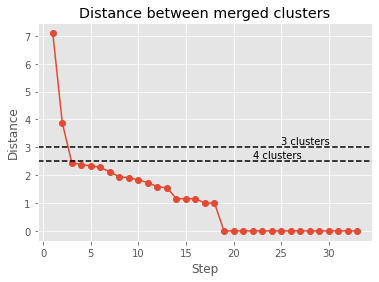

In [ ]:
dist_rev = dist[::-1]
idxs = range(1, len(dist) + 1)
plt.plot(idxs, dist_rev, marker='o')
plt.title('Distance between merged clusters')
plt.xlabel('Step')
plt.ylabel('Distance')
plt.axhline(3, c='k', linestyle='dashed')
plt.axhline(2.52, c='k', linestyle='dashed')
plt.text(25, 3.1, '3 clusters')
plt.text(22, 2.6, '4 clusters')

Из картинки видно, что если мы остановимся объединять кластеры при расстоянии равном примерно 2.5, мы получим 4 кластера, а при равном 3 - 3 кластера.

Однако, строго говоря, этот способ всё ещё немасштабируем для больших данных. Но его можно просто поправить, включая в график не все подряд слияния, а только несколько последних. И если уж мы совсем хотим автомаизировать процесс, то факт сильного изменения расстояний между кластерами можно фиксировать с помощью производной: там где график выходит на горизонталь, производная станет почти нулём.

## 2. Кластеризация методом k-means (k-средних)

In [ ]:
df = pd.read_csv("beverage_r.csv", sep=";", index_col='numb.obs')
df.head()

,COKE,D_COKE,D_PEPSI,D_7UP,PEPSI,SPRITE,TAB,SEVENUP
numb.obs,,,,,,,,
1,1,0,0,0,1,1,0,1
2,1,0,0,0,1,0,0,0
3,1,0,0,0,1,0,0,0
4,0,1,0,1,0,0,1,0
5,1,0,0,0,1,0,0,0


В scikit-learn процедура настройки и использования моделей часто проходит по одной и той же схеме:
1. Инициализация модели, задание её параметров,
2. Подгонка модели (метод fit и/или fit_transform),
3. Предсказание для новых наблюдений (метод predict).

Для кластеризации методом k-means необходимо задать k наперёд. Попробуем k = 2.

In [ ]:
# инициализация модели
model = KMeans(n_clusters=2, random_state=42)
# random_state - зерно датчика случайных чисел.
# При каждом новом вызове с одинаковыми random_state модель будет давать
# одинаковые результаты.

In [ ]:
# подгонка модели по данным из df
model.fit(df)

KMeans(n_clusters=2, random_state=42)

In [ ]:
# Результат кластеризации на данных df
model.labels_

array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1], dtype=int32)

In [ ]:
# координаты центров кластеров
model.cluster_centers_

array([[ 9.52380952e-01,  2.38095238e-01,  4.76190476e-02,
        -8.32667268e-17,  7.61904762e-01,  4.28571429e-01,
         4.76190476e-02,  3.80952381e-01],
       [ 1.11022302e-16,  9.23076923e-01,  5.38461538e-01,
         5.38461538e-01, -5.55111512e-17,  1.53846154e-01,
         7.69230769e-01,  7.69230769e-02]])

In [ ]:
# предсказание для новых наблюдений. Метод predict.
new_items = [
    [1, 1, 1, 1, 1, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 0]
]
model.predict(new_items)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"


array([0, 2], dtype=int32)

Модель выше разбивала на два кластера.
Как определить число кластеров?
Применим модель для разного числа кластеров, чтобы построить график каменистой осыпи. Метод ```inertia_``` вернёт сумму расстояний от каждой точки данных до центра ближайшего к ней кластера. Таким образом, кластеризацию можно считать условно хорошей, когда инерция перестаёт сильно уменьшаться при увеличении числа кластеров.

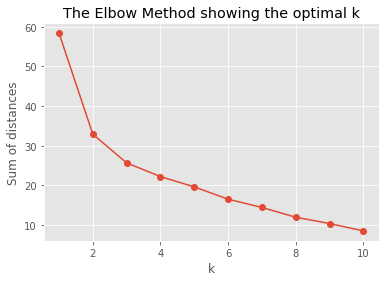

In [ ]:
K = range(1, 11)
models = [KMeans(n_clusters=k, random_state=42).fit(df) for k in K]
dist = [model.inertia_ for model in models]

# Plot the elbow
plt.plot(K, dist, marker='o')
plt.xlabel('k')
plt.ylabel('Sum of distances')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Ранее мы решили, что три кластера - это оптимальный выбор. Теперь хочется посмотреть на список наблюдений, составляющий данные кластеры, и посмотреть, чем они отличаются друг от друга. Для этого применим метод ```labels_```, а затем посчитаем средние значения факторов для каждого кластера.

In [ ]:
model = KMeans(n_clusters=3, random_state=42)
model.fit(df)
df['cluster'] = model.labels_
df.groupby('cluster').mean()

,COKE,D_COKE,D_PEPSI,D_7UP,PEPSI,SPRITE,TAB,SEVENUP
cluster,,,,,,,,
0,0.727273,0.272727,0.090909,0.090909,0.454545,1.0,0.090909,0.454545
1,0.000000,1.000000,0.545455,0.545455,0.000000,0.0,0.909091,0.000000
2,1.000000,0.250000,0.083333,0.000000,0.916667,0.0,0.000000,0.333333


In [ ]:
df.groupby('cluster').size()

cluster
0    11
1    11
2    12
dtype: int64